## Exoplanet Group Study - Project Notebook

##### Tamzin Jones

In [2]:
# Setup

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

print("Setup finished.")

Mounted at /content/drive
Setup finished.


### Session 1 - Tuesday, 13.01.26

I am in Team 2 - Target Selection and Data Analysis.


### Session 2 - Thursday, 15.01.26

**Making management plan**



*   Get Exoplanet Archive data.
    *   Filter to find sub-Neptunes.
    *   Provide a list of sub-Neptunes (high TSMs or high equilibrium temperature?) to group 1.
*   Write code to detect features in spectra.
    *   Code will find maxima in spectra (where and how tall).
    *   Will be used on simulated atmophere data provided by group 1.



**Researching how we should select sub-Neptunes in the sample**



1.   Download Exoplanet Archive.
2.   Filter so only sub-Neptunes are included (by radius range).
3.   Separate the sub-Neptunes into groups like cool, warm, hot based on equilibrium temperature.
4.   Sort by highest TSM in each group and select those with highest TSMs (good observability).


Graphs below from Brande et al. (2024).

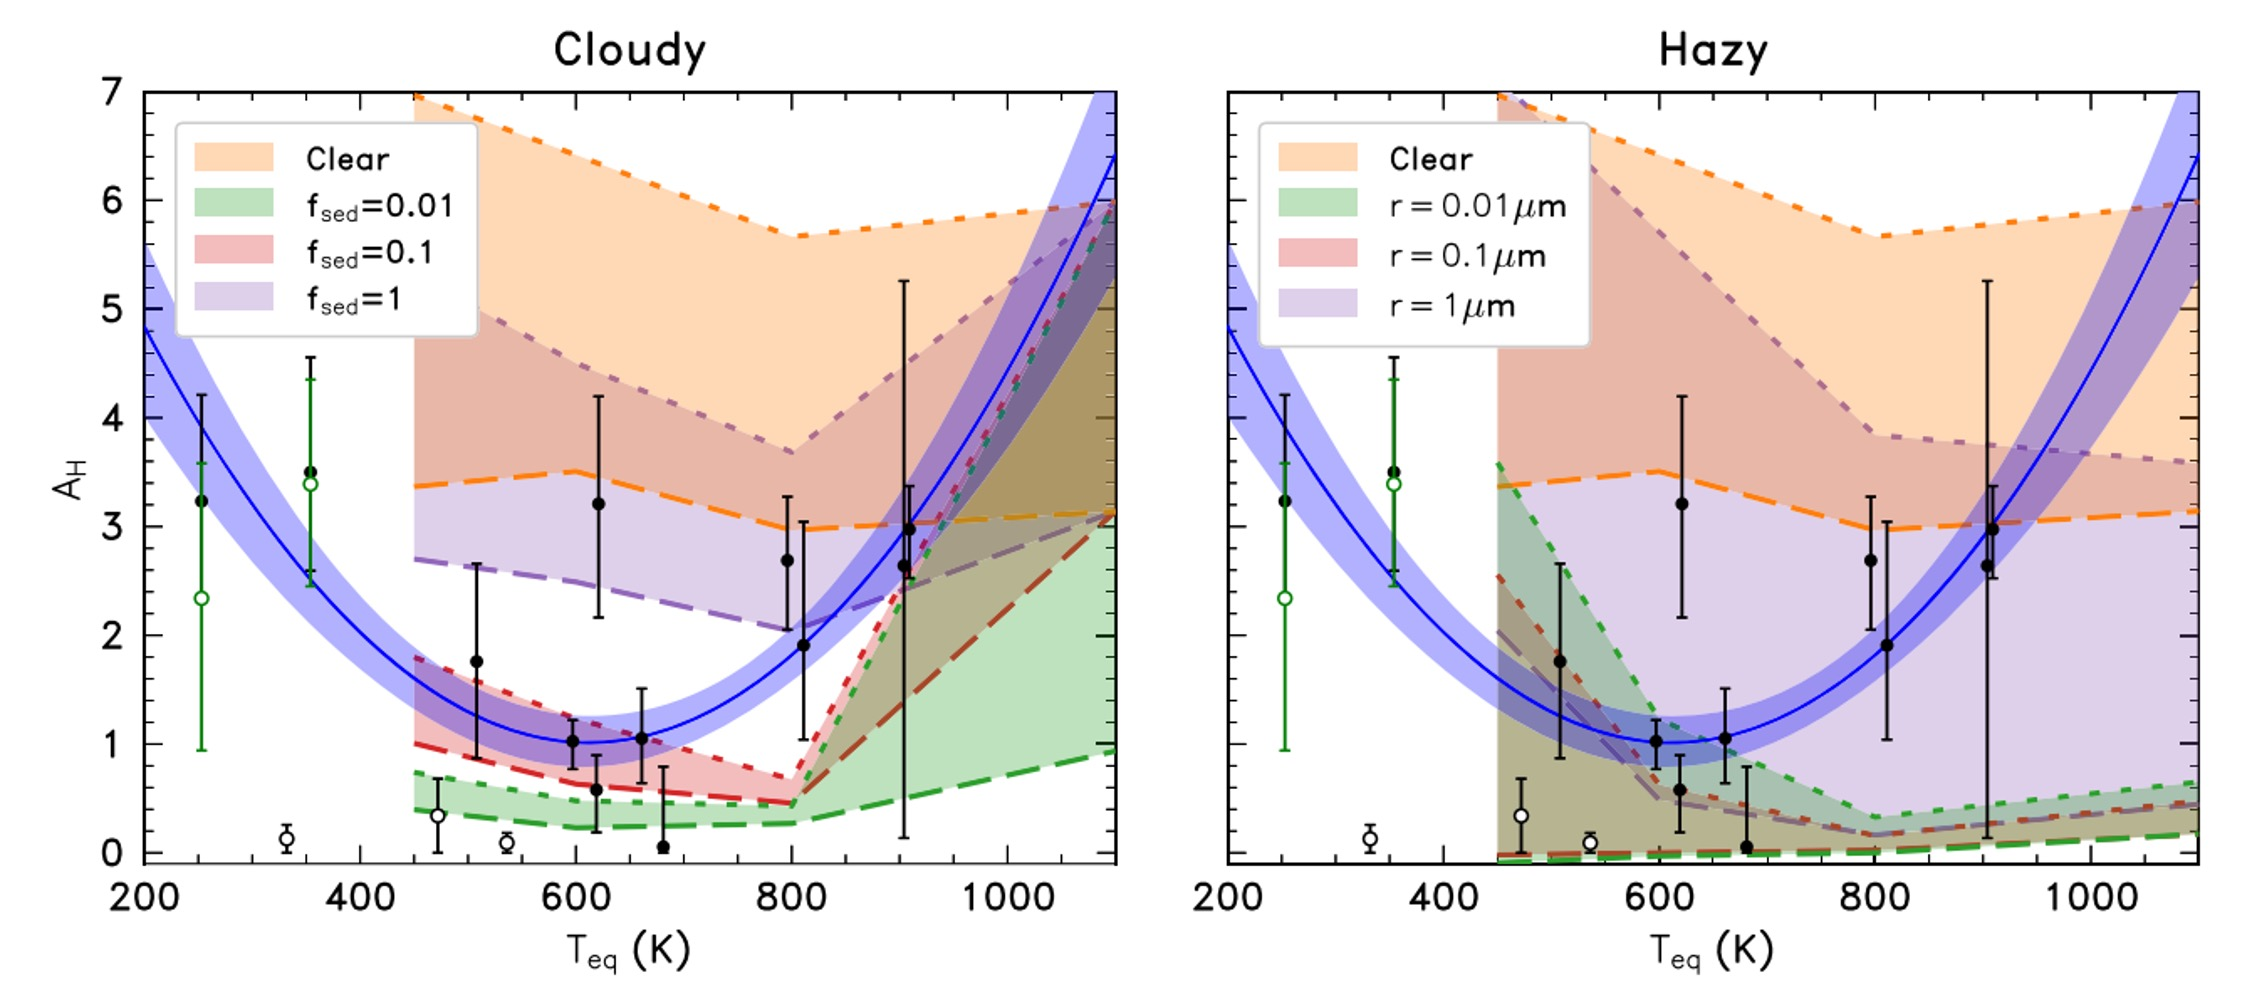

Working with Abi to figure out which parameters we need to get out fo the Exoplanet Archive.

To calculate TSM we need apparent magnitude of the host star in the J band.

Source: [Kempton et al. (2018), "A Framework for Prioritizing the TESS Planetary Candidates Most Amenable to Atmospheric Characterization"](https://iopscience.iop.org/article/10.1088/1538-3873/aadf6f/pdf)

/tmp/ipython-input-1655172112.py:31: RuntimeWarning: Mean of empty slice
  st_teff_err = np.nanmean([df["st_tefferr1"], -df["st_tefferr2"]], axis=0)
/tmp/ipython-input-1655172112.py:32: RuntimeWarning: Mean of empty slice
  st_rad_err  = np.nanmean([df["st_raderr1"],  -df["st_raderr2"]],  axis=0)
/tmp/ipython-input-1655172112.py:33: RuntimeWarning: Mean of empty slice
  a_err       = np.nanmean([df["pl_orbsmaxerr1"], -df["pl_orbsmaxerr2"]], axis=0) * AU
/tmp/ipython-input-1655172112.py:34: RuntimeWarning: Mean of empty slice
  pl_rade_err  = np.nanmean([df["pl_radeerr1"],  -df["pl_radeerr2"]],  axis=0)
/tmp/ipython-input-1655172112.py:35: RuntimeWarning: Mean of empty slice
  pl_masse_err = np.nanmean([df["pl_masseerr1"], -df["pl_masseerr2"]], axis=0)
/tmp/ipython-input-1655172112.py:36: RuntimeWarning: Mean of empty slice
  sy_jmag_err  = np.nanmean([df["sy_jmagerr1"],  -df["sy_jmagerr2"]],  axis=0)


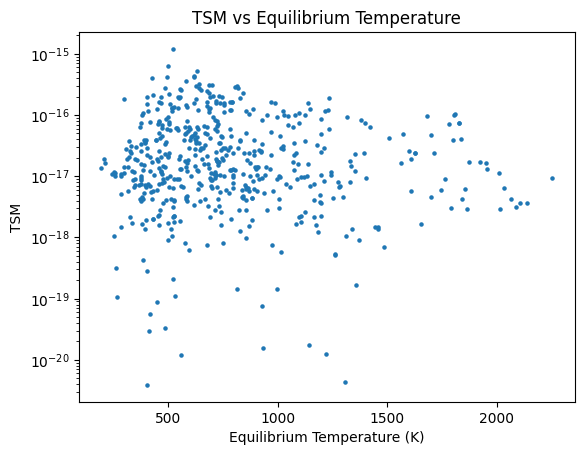

Minimum value of equilibrium temperature: 1.080092482737876K
Maximum value of equilibrium temperature: 7114.214909696282K
Number of TSMs found: 39235


In [3]:
# Using UNFILTERED spreadsheet containing all exoplanets (not just sub-Neptunes) and all columns!!!!!!
# Filtered list will use radii between 1.3 and 2.8
# (future note: the limits have changed to 1.5 to 4)
# Will apply this code to the filtered list when I get it
file_path = "/content/drive/My Drive/Y3 Exoplanet Group Study/archive_data_15.01.26.xlsx"

# Reading the excel file
df = pd.read_excel(
    file_path,
    comment="#"
)

df.columns = df.columns.str.strip()

# Constants
R_sun = 6.957 * 10 ** 8
AU = 1.496 * 10 ** 11

# Assuming all the sub-Neptunes in the list have a Bond albedo similar to that of Neptune
A_bond_neptune = 0.3

# Extracting values
pl_rade = np.asarray(df["pl_rade"], dtype=float)
pl_eqt  = np.asarray(df["pl_eqt"], dtype=float)
st_teff = np.asarray(df["st_teff"], dtype=float)
st_rad  = np.asarray(df["st_rad"], dtype=float) * R_sun
pl_masse = np.asarray(df["pl_masse"], dtype=float)
sy_jmag = np.asarray(df["sy_jmag"], dtype=float)
a = np.asarray(df["pl_orbsmax"], dtype=float) * AU

# 1 sigma uncertainties
st_teff_err = np.nanmean([df["st_tefferr1"], -df["st_tefferr2"]], axis=0)
st_rad_err  = np.nanmean([df["st_raderr1"],  -df["st_raderr2"]],  axis=0)
a_err       = np.nanmean([df["pl_orbsmaxerr1"], -df["pl_orbsmaxerr2"]], axis=0) * AU
pl_rade_err  = np.nanmean([df["pl_radeerr1"],  -df["pl_radeerr2"]],  axis=0)
pl_masse_err = np.nanmean([df["pl_masseerr1"], -df["pl_masseerr2"]], axis=0)
sy_jmag_err  = np.nanmean([df["sy_jmagerr1"],  -df["sy_jmagerr2"]],  axis=0)

# Calculating equilibrium temperature for each planet
T_eq_calc = st_teff * np.sqrt(st_rad / (2 * a)) * (1 - A_bond_neptune)**0.25

df["pl_eqt_calc"] = T_eq_calc

df["pl_eqt_calc"] = df["pl_eqt_calc"].where(
    (df["pl_eqt_calc"] > 0) & np.isfinite(df["pl_eqt_calc"])
)

# Equilibrium temperature unccertainties
frac_Teq_err = np.sqrt(
    (st_teff_err / st_teff)**2
    + 0.25 * (st_rad_err / st_rad)**2
    + 0.25 * (a_err / a)**2
)

T_eq_err = T_eq_calc * frac_Teq_err
df["pl_eqt_calc_err"] = T_eq_err

# Function for the scale factor in the TSM formula (see Kempton et al. 2018)
def tsm_scale_factor(Rp):

    S = np.full_like(Rp, np.nan, dtype=float)

    S[(Rp >= 1.5) & (Rp < 2.75)] = 1.26

    S[(Rp >= 2.75) & (Rp <= 4.0)] = 1.28

    return S

S = tsm_scale_factor(pl_rade)

# Calculating TSM for each planet
TSM = S * (pl_rade**3 * T_eq_calc) / (pl_masse * st_rad**2) * 10**(-sy_jmag / 5)

TSM = np.where(
    (TSM > 0) & np.isfinite(TSM),
    TSM,
    np.nan
)

df["TSM"] = TSM

# TSM uncertainties
frac_TSM_err = np.sqrt(
    (3 * pl_rade_err / pl_rade)**2
    + (T_eq_err / T_eq_calc)**2
    + (pl_masse_err / pl_masse)**2
    + (2 * st_rad_err / st_rad)**2
    + ((np.log(10) / 5) * sy_jmag_err)**2
)

TSM_err = TSM * frac_TSM_err
df["TSM_err"] = TSM_err

# Plotting TSM vs equilibrium temperature to check it looks reasonable
plt.scatter(T_eq_calc, TSM, s = 5)
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature")
plt.yscale("log")
plt.show()

# Finding valid min and max values of equilibrium temperature
# This will be a good sanity check when I get the filtered list, should be around 200K and 3000K respectively
print(f"Minimum value of equilibrium temperature: {np.nanmin(T_eq_calc)}K")
print(f"Maximum value of equilibrium temperature: {np.nanmax(T_eq_calc)}K")

print(f"Number of TSMs found: {len(TSM)}")

### Session 3 - Friday, 16.01.26

Continued writing the code above:

*   Implemented the TSM formula.
*   Plotted TSM vs equilibrium temperature graph.

While waiting for the filtered spreadsheet, I'll start working on separating the planets into equlibrium temperature bins.

In [ ]:
# Temperature bins:
# Cool: Up to 500K
# Warm: 500 to 800K
# Hot: 800 to 1100K
# Very hot: 1100 to 1400K
# Extremely hot: 1400 to 1700K
# Hottest: 1700K and over

# Rename to make clearer? Just number the groups?

Also need to add code to estimate errors on equilibrium temperature and TSM.

### Session 4 - Tuesday, 20.01.26

Adding Stan's filtering code...

In [ ]:
# --- Stan's filtering code ---

# see first few rows of 'archive data'
useful_columns_only = df[['pl_name', 'pl_orbper', 'pl_orbsmax', 'pl_masse', 'pl_rade',
                'pl_trandep', 'pl_trandur', 'pl_orbeccen', 'pl_orbincl', 'st_rad',
                'st_mass', 'st_teff', 'pl_ratror','sy_jmag', 'discoverymethod', 'default_flag']]

# filter for default parameter rows only
default_planets = useful_columns_only[useful_columns_only['default_flag'] == 1]

# set size limits for filtering
radius_lower = 1.5 # earth radii
radius_upper = 4

# filter for planets in size limits
filtered_sizes = default_planets[
    (default_planets['pl_rade'] >= radius_lower) &
    (default_planets['pl_rade'] <= radius_upper)
]

# checks
print('initial downloaded table dimensions:', df.shape)
print('column filtered table dimensions:', useful_columns_only.shape)
print('default planets table dimensions:', default_planets.shape)
print('size filtered table dimensions:', filtered_sizes.shape)
filtered_sizes.head()

Implementing Stan's filtering code into my code...


Initial downloaded table dimensions: (39235, 111)
Column filtered table dimensions: (39235, 29)
Default planets table dimensions: (6071, 29)
Size filtered table dimensions: (2467, 29)



/tmp/ipython-input-2510572228.py:59: RuntimeWarning: Mean of empty slice
  st_teff_err = np.nanmean([df_work["st_tefferr1"], -df_work["st_tefferr2"]], axis=0)
/tmp/ipython-input-2510572228.py:60: RuntimeWarning: Mean of empty slice
  st_rad_err  = np.nanmean([df_work["st_raderr1"],  -df_work["st_raderr2"]],  axis=0)
/tmp/ipython-input-2510572228.py:61: RuntimeWarning: Mean of empty slice
  a_err       = np.nanmean([df_work["pl_orbsmaxerr1"], -df_work["pl_orbsmaxerr2"]], axis=0) * AU
/tmp/ipython-input-2510572228.py:62: RuntimeWarning: Mean of empty slice
  pl_rade_err  = np.nanmean([df_work["pl_radeerr1"],  -df_work["pl_radeerr2"]],  axis=0)
/tmp/ipython-input-2510572228.py:63: RuntimeWarning: Mean of empty slice
  pl_masse_err = np.nanmean([df_work["pl_masseerr1"], -df_work["pl_masseerr2"]], axis=0)
/tmp/ipython-input-2510572228.py:64: RuntimeWarning: Mean of empty slice
  sy_jmag_err  = np.nanmean([df_work["sy_jmagerr1"],  -df_work["sy_jmagerr2"]],  axis=0)


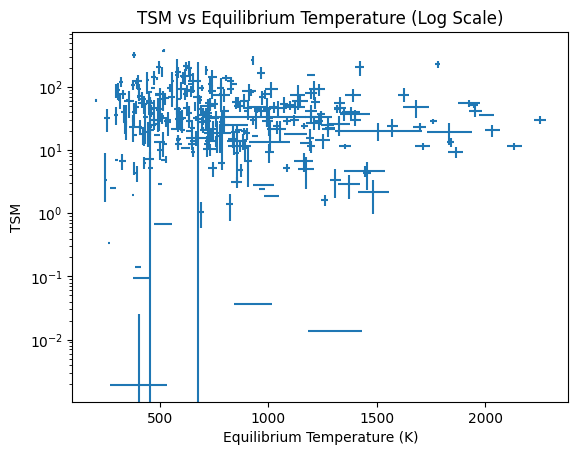

Minimum value of equilibrium temperature: 177.45400453754922K
Maximum value of equilibrium temperature: 2402.823836343809K
Number of TSMs found (excluding nans): 306


In [43]:
file_path = "/content/drive/My Drive/Y3 Exoplanet Group Study/archive_data_15.01.26.xlsx"

# Reading the excel file
df = pd.read_excel(
    file_path,
    comment="#"
)

df.columns = df.columns.str.strip()

# Filtering code
# I needed to add a few more columns to useful_columns_only for error calculations
useful_columns_only = df[['pl_name', 'pl_orbper', 'pl_orbsmax', 'pl_masse', 'pl_rade',
                'pl_trandep', 'pl_trandur', 'pl_orbeccen', 'pl_orbincl', 'st_rad',
                'st_mass', 'st_teff', 'pl_ratror','sy_jmag', 'discoverymethod', 'pl_eqt',
                'st_tefferr1', 'st_tefferr2', 'st_raderr1', 'st_raderr2', 'pl_orbsmaxerr1',
                'pl_orbsmaxerr2', 'pl_radeerr1', 'pl_radeerr2', 'pl_masseerr1', 'pl_masseerr2',
                'sy_jmagerr1', 'sy_jmagerr2', 'default_flag']]

default_planets = useful_columns_only[useful_columns_only['default_flag'] == 1]

radius_lower = 1.5
radius_upper = 4

filtered_sizes = default_planets[
    (default_planets['pl_rade'] >= radius_lower) &
    (default_planets['pl_rade'] <= radius_upper)
]

# Checks for filtering code
print("")
print('Initial downloaded table dimensions:', df.shape)
print('Column filtered table dimensions:', useful_columns_only.shape)
print('Default planets table dimensions:', default_planets.shape)
print('Size filtered table dimensions:', filtered_sizes.shape)
print("")

df_work = filtered_sizes.copy()

# Constants
R_sun = 6.957 * 10 ** 8
AU = 1.496 * 10 ** 11

# Assuming all the sub-Neptunes in the list have a Bond albedo similar to that of Neptune
A_bond_neptune = 0.3

# Extracting values
pl_rade = np.asarray(df_work["pl_rade"], dtype=float)
pl_eqt  = np.asarray(df_work["pl_eqt"], dtype=float)
st_teff = np.asarray(df_work["st_teff"], dtype=float)
st_rad  = np.asarray(df_work["st_rad"], dtype=float)
pl_masse = np.asarray(df_work["pl_masse"], dtype=float)
sy_jmag = np.asarray(df_work["sy_jmag"], dtype=float)
a = np.asarray(df_work["pl_orbsmax"], dtype=float) * AU

st_rad_m = st_rad * R_sun

# 1 sigma uncertainties
st_teff_err = np.nanmean([df_work["st_tefferr1"], -df_work["st_tefferr2"]], axis=0)
st_rad_err  = np.nanmean([df_work["st_raderr1"],  -df_work["st_raderr2"]],  axis=0)
a_err       = np.nanmean([df_work["pl_orbsmaxerr1"], -df_work["pl_orbsmaxerr2"]], axis=0) * AU
pl_rade_err  = np.nanmean([df_work["pl_radeerr1"],  -df_work["pl_radeerr2"]],  axis=0)
pl_masse_err = np.nanmean([df_work["pl_masseerr1"], -df_work["pl_masseerr2"]], axis=0)
sy_jmag_err  = np.nanmean([df_work["sy_jmagerr1"],  -df_work["sy_jmagerr2"]],  axis=0)

# Calculating equilibrium temperature for each planet
T_eq_calc = st_teff * np.sqrt(st_rad_m / (2 * a)) * (1 - A_bond_neptune)**0.25

df_work["pl_eqt_calc"] = T_eq_calc

df_work["pl_eqt_calc"] = df_work["pl_eqt_calc"].where(
    (df_work["pl_eqt_calc"] > 0) & np.isfinite(df_work["pl_eqt_calc"])
)

# Equilibrium temperature unccertainties
frac_Teq_err = np.sqrt(
    (st_teff_err / st_teff)**2
    + 0.25 * (st_rad_err / st_rad)**2
    + 0.25 * (a_err / a)**2
)

T_eq_err = T_eq_calc * frac_Teq_err
df_work["pl_eqt_calc_err"] = T_eq_err

# Function for the scale factor in the TSM formula (see Kempton et al. 2018)
def tsm_scale_factor(Rp):

    S = np.full_like(Rp, np.nan, dtype=float)

    S[(Rp >= 1.5) & (Rp < 2.75)] = 1.26

    S[(Rp >= 2.75) & (Rp <= 4.0)] = 1.28

    return S

S = tsm_scale_factor(pl_rade)

# Calculating TSM for each planet
TSM = S * (pl_rade**3 * T_eq_calc) / (pl_masse * st_rad**2) * 10**(-sy_jmag / 5)

TSM = np.where(
    (TSM > 0) & np.isfinite(TSM),
    TSM,
    np.nan
)

df_work["TSM"] = TSM

# TSM uncertainties
frac_TSM_err = np.sqrt(
    (3 * pl_rade_err / pl_rade)**2
    + (T_eq_err / T_eq_calc)**2
    + (pl_masse_err / pl_masse)**2
    + (2 * st_rad_err / st_rad)**2
    + ((np.log(10) / 5) * sy_jmag_err)**2
)

TSM_err = TSM * frac_TSM_err
df_work["TSM_err"] = TSM_err

# Plotting TSM vs equilibrium temperature to check it looks reasonable
plt.errorbar(T_eq_calc, TSM, xerr = T_eq_err, yerr = TSM_err, linestyle = 'none')
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature (Log Scale)")
plt.yscale("log")
plt.show()

# Finding valid min and max values of equilibrium temperature
# This will be a good sanity check when I get the filtered list, should be around 200K and 3000K respectively
print(f"Minimum value of equilibrium temperature: {np.nanmin(T_eq_calc)}K")
print(f"Maximum value of equilibrium temperature: {np.nanmax(T_eq_calc)}K")

print(f"Number of TSMs found (excluding nans): {np.sum(np.isfinite(TSM))}")

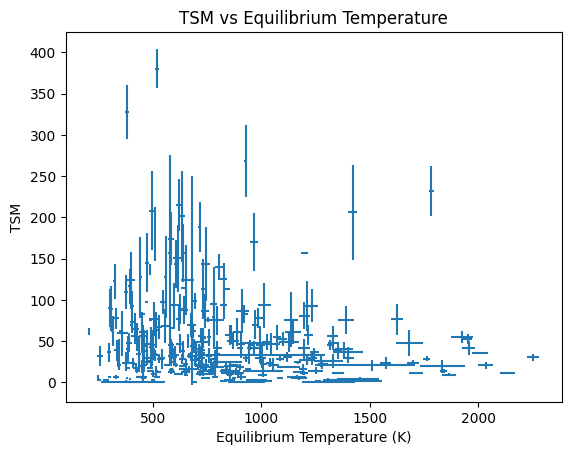

In [44]:
# Graph on linear scale

plt.errorbar(T_eq_calc, TSM, xerr = T_eq_err, yerr = TSM_err, linestyle = 'none')
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature")
#plt.yscale("log")
plt.show()

In [45]:
# Printing the head of the df_work table to check

df_work.head()

,pl_name,pl_orbper,pl_orbsmax,pl_masse,pl_rade,pl_trandep,pl_trandur,pl_orbeccen,pl_orbincl,st_rad,...,pl_radeerr2,pl_masseerr1,pl_masseerr2,sy_jmagerr1,sy_jmagerr2,default_flag,pl_eqt_calc,pl_eqt_calc_err,TSM,TSM_err
125,55 Cnc e,0.736547,0.01544,7.9900,1.875000,NaN,NaN,0.05000,83.59000,0.943,...,-0.029000,0.3200,-0.3300,0.244,-0.244,1,1782.770470,11.669681,231.899402,30.170372
176,AU Mic b,8.463080,0.06490,NaN,3.956770,0.2379,3.4927,0.00577,89.57917,0.744,...,-0.145717,NaN,NaN,0.017,-0.017,1,549.263274,16.382457,NaN,NaN
187,AU Mic c,18.859690,0.11080,NaN,2.522021,0.0970,4.2360,0.00338,89.22655,0.744,...,-0.246598,NaN,NaN,0.017,-0.017,1,420.371273,12.509773,NaN,NaN
205,BD+20 594 b,41.685500,NaN,22.2481,2.578070,0.0490,NaN,0.00000,89.55000,1.080,...,-0.112090,9.5349,-9.5349,0.022,-0.022,1,NaN,NaN,NaN,NaN
336,CoRoT-24 b,5.113400,0.05600,5.7000,3.700000,NaN,2.8500,0.00000,86.50000,0.860,...,-0.400000,NaN,NaN,0.024,-0.024,1,855.588873,53.943624,25.130927,NaN


In [46]:
# Creating a dataframe that has ONLY sub-Neptunes with valid (not nan) TSMs and TSM errors

df_valid_TSM_pre_err_filtering = df_work[np.isfinite(df_work["TSM"])].copy()
df_valid_TSM = df_valid_TSM_pre_err_filtering[np.isfinite(df_valid_TSM_pre_err_filtering["TSM_err"])].copy()

# Resetting the index numbers
df_valid_TSM.reset_index(drop=True, inplace=True)

# Printing the head to check
df_valid_TSM.head()

,pl_name,pl_orbper,pl_orbsmax,pl_masse,pl_rade,pl_trandep,pl_trandur,pl_orbeccen,pl_orbincl,st_rad,...,pl_radeerr2,pl_masseerr1,pl_masseerr2,sy_jmagerr1,sy_jmagerr2,default_flag,pl_eqt_calc,pl_eqt_calc_err,TSM,TSM_err
0,55 Cnc e,0.736547,0.01544,7.99,1.875,NaN,NaN,0.05,83.59,0.943,...,-0.029,0.32,-0.33,0.244,-0.244,1,1782.770470,11.669681,231.899402,30.170372
1,EPIC 201595106 b,0.877240,0.01770,7.67,1.565,NaN,NaN,0.00,78.20,0.980,...,-0.079,0.75,-0.75,0.019,-0.019,1,1863.815806,32.841543,9.321140,1.755870
2,EPIC 220674823 b,0.571313,0.01314,7.80,1.676,0.0241,1.540,0.00,85.20,0.990,...,-0.037,0.71,-0.70,0.023,-0.023,1,2135.517534,34.593995,11.623335,1.351408
3,EPIC 220674823 c,13.339890,0.10730,7.32,2.840,0.0693,3.661,0.17,88.62,0.990,...,-0.080,2.49,-2.38,0.023,-0.023,1,747.310292,11.985551,21.423207,7.441341
4,EPIC 229004835 b,16.141132,0.12370,10.40,2.332,NaN,NaN,0.23,88.08,0.999,...,-0.094,1.60,-1.50,0.032,-0.032,1,735.517003,9.527675,17.449564,3.282201


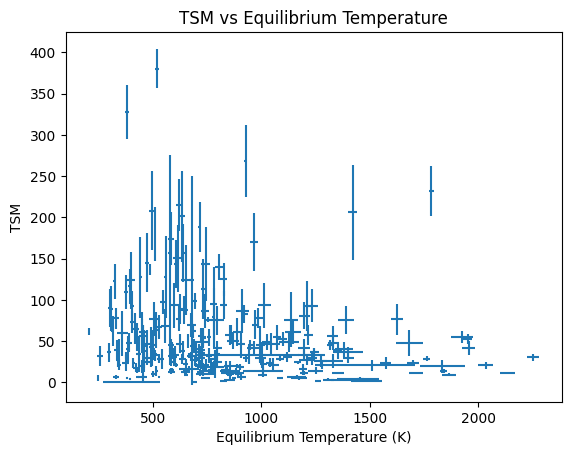

In [47]:
# Extracting values
T_eq_calc_valid = np.asarray(df_valid_TSM["pl_eqt_calc"], dtype=float)
TSM_valid = np.asarray(df_valid_TSM["TSM"], dtype=float)
T_eq_err_valid = np.asarray(df_valid_TSM["pl_eqt_calc_err"], dtype=float)
TSM_err_valid = np.asarray(df_valid_TSM["TSM_err"], dtype=float)

plt.errorbar(T_eq_calc_valid, TSM_valid, xerr = T_eq_err_valid, yerr = TSM_err_valid, linestyle = 'none')
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature")
#plt.yscale("log")
plt.show()

In [48]:
# Separating into temperature bins
bin_labels = [
    "Cool (<500 K)",
    "Warm (500–800 K)",
    "Hot (800–1100 K)",
    "Very hot (1100–1400 K)",
    "Extremely hot (1400–1700 K)",
    "Hottest (>1700 K)"
]

temp_bins = [0, 500, 800, 1100, 1400, 1700, np.inf]

# Putting planets into their bins
df_valid_TSM["Teq_bin"] = pd.cut(
    df_valid_TSM["pl_eqt_calc"],
    bins=temp_bins,
    labels=bin_labels,
    right=False  # includes lower end, excludes upper, so 500K would go into 'Warm', not 'Cool'
)

# How many top-TSM planets sampled per temperature bin
# Can be changed depending on what we need!!!!!
N_sample_per_bin = 5

# Selecting the highest TSMs
highest_TSM_per_bin = (
    df_valid_TSM
    .dropna(subset=["Teq_bin"])   # safety check
    .sort_values("TSM", ascending=False)
    .groupby("Teq_bin")
    .head(N_sample_per_bin)
)

# Only keeping relevant columns in selection_table
selection_table = highest_TSM_per_bin[
    ["pl_name", "pl_eqt_calc", "pl_eqt_calc_err", "TSM", "TSM_err", "Teq_bin"]
].sort_values(["Teq_bin", "TSM"], ascending=[True, False])

selection_table

/tmp/ipython-input-2436797851.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Teq_bin")


,pl_name,pl_eqt_calc,pl_eqt_calc_err,TSM,TSM_err,Teq_bin
138,L 98-59 d,380.655082,9.834533,327.810048,32.623071,Cool (<500 K)
26,HD 191939 d,495.297849,12.926294,208.186783,48.155983,Cool (<500 K)
206,TOI-2443 b,473.045379,10.423368,145.333107,36.212895,Cool (<500 K)
192,TOI-2015 b,485.847388,4.288458,136.621895,6.440472,Cool (<500 K)
16,HD 110067 f,443.323161,6.418171,127.828900,49.085402,Cool (<500 K)
9,GJ 1214 b,518.401295,7.993120,380.581912,23.734513,Warm (500–800 K)
19,HD 136352 c,619.413064,12.505880,214.889523,31.558617,Warm (500–800 K)
11,GJ 3090 b,633.292672,16.096907,201.589519,55.229135,Warm (500–800 K)
32,HD 219134 c,715.390832,5.515579,188.391639,30.139821,Warm (500–800 K)
40,HD 260655 c,509.990655,3.036457,179.833960,32.906733,Warm (500–800 K)


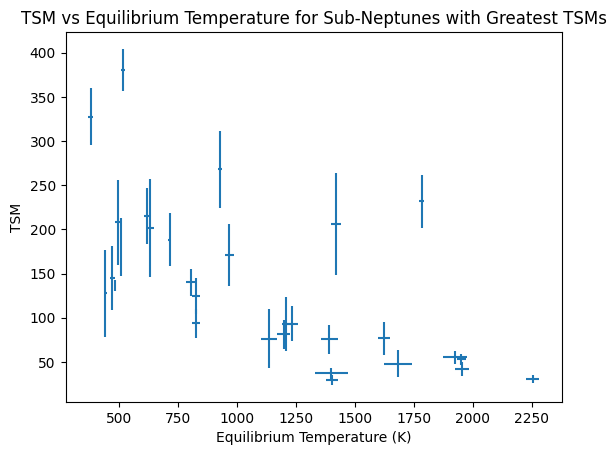

In [50]:
# Extracting values from selection_table
sample_TSM_vals = np.asarray(selection_table["TSM"], dtype=float)
sample_TSM_vals_errs = np.asarray(selection_table["TSM_err"], dtype=float)
sample_teq_vals = np.asarray(selection_table["pl_eqt_calc"], dtype=float)
sample_teq_vals_errs = np.asarray(selection_table["pl_eqt_calc_err"], dtype=float)

# Plotting
plt.errorbar(sample_teq_vals, sample_TSM_vals, xerr = sample_teq_vals_errs, yerr = sample_TSM_vals_errs, linestyle = 'none')
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature for Sub-Neptunes with Greatest TSMs")
plt.show()

Everything seems to be working!